# Notebook relevant version changes

<div style="border-radius:10px; border: #babab5 solid; padding: 15px; background-color: #e6f9ff; font-size:100%;">
   
* V11 (CV 1-fold: 90.76 / LB: 97.66)
    * Create feature processing per dataset inside the  class FeatureProcessorClass
    * Renaming of the features per dataset
    * Remove latitude/longitude columns for model
    * Add mean_price_per_mwh_gas as feature


* V21 (CV 1-fold: 78.99 / LB: 86.43)
    * Add revealed_target lags from 2 to 7 days ago - inspired from [[Enefit] Baseline + cross-validation ☀️](https://www.kaggle.com/code/vincentschuler/enefit-baseline-cross-validation)
    * Use custom N_days_lags to specify the max number of revealed_target day lags

    
* V23 (CV 1-fold: 72.96 / LB: 83.79)
    * Map latitude & longitude for each county, using code from [mapping locations and county codes
](https://www.kaggle.com/code/fabiendaniel/mapping-locations-and-county-codes)
    * *historical_weather* and *forecast_weather* group by county too, and specify aggegate statistics  

# Introduction 
> 📌**Note**: If you liked or forked this notebook, please consider upvoting ⬆️⬆️ It encourages to keep posting relevant content

<div style="border-radius:10px; border: #babab5 solid; padding: 15px; background-color: #e6f9ff; font-size:100%; ">
    
This notebook covers the following:
* Pre-processing of the different datasets 
* Basic merging of the datasets 
* Simple eature engineering
* XGBoost starter model 
* Next steps

# Competition Description
<img src ="https://www.energy.gov/sites/default/files/styles/full_article_width/public/Prosumer-Blog%20sans%20money-%201200%20x%20630-01_0.png?itok=2a3YSkUb" width=600>

> 📌**Note**:  Energy prosumers are individuals, businesses, or organizations that both consume and produce energy. This concept represents a shift from the traditional model where consumers simply purchase energy from utilities and rely on centralized power generation sources. Energy prosumers are actively involved in the energy ecosystem by generating their own electricity, typically through renewable energy sources like solar panels (or wind turbines, small-scale hydropower etc.). They also consume energy from the grid when their own generation is insufficient to meet their needs

<div style="border-radius:10px; border: #babab5 solid; padding: 15px; background-color: #e6f9ff; font-size:100%; ">
    
* The number of prosumers is rapidly increasing, associated with higher energy imbalance - increased operational costs, potential grid instability, and inefficient use of energy resources.
* The goal of the competition is to create an energy prediction model of prosumers to reduce energy imbalance costs
* If solved, it would reduce the imbalance costs, improve the reliability of the grid, and make the integration of prosumers into the energy system more efficient and sustainable.
*  Moreover, it could potentially incentivize more consumers to become prosumers and thus promote renewable energy production and use.

# Data Description
> 📌**Note**:  Your challenge in this competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. You'll have access to weather data, the relevant energy prices, and records of the installed photovoltaic capacity. <br> <br>
This is a forecasting competition using the time series API. The private leaderboard will be determined using real data gathered after the submission period closes.

<div style="border-radius:10px; border: #babab5 solid; padding: 15px; background-color: #e6f9ff; font-size:100%; ">

## Files

**train.csv**

- `county` - An ID code for the county.
- `is_business` - Boolean for whether or not the prosumer is a business.
- `product_type` - ID code with the following mapping of codes to contract types: `{0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}`.
- `target` - The consumption or production amount for the relevant segment for the hour. The segments are defined by the `county`, `is_business`, and `product_type`.
- `is_consumption` - Boolean for whether or not this row's target is consumption or production.
- `datetime` - The Estonian time in EET (UTC+2) / EEST (UTC+3).
- `data_block_id` - All rows sharing the same `data_block_id` will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather `data_block_id` for predictions made on October 31st is 100 then the historic weather `data_block_id` for October 31st will be 101 as the historic weather data is only actually available the next day.
- `row_id` - A unique identifier for the row.
- `prediction_unit_id` - A unique identifier for the `county`, `is_business`, and `product_type` combination. _New prediction units can appear or dissappear in the test set_.

**gas\_prices.csv**

- `origin_date` - The date when the day-ahead prices became available.
- `forecast_date` - The date when the forecast prices should be relevant.
- `[lowest/highest]_price_per_mwh` - The lowest/highest price of natural gas that on the day ahead market that trading day, in Euros per megawatt hour equivalent.
- `data_block_id`

**client.csv**

- `product_type`
- `county` - An ID code for the county. See `county_id_to_name_map.json` for the mapping of ID codes to county names.
- `eic_count` - The aggregated number of consumption points (EICs - European Identifier Code).
- `installed_capacity` - Installed photovoltaic solar panel capacity in kilowatts.
- `is_business` - Boolean for whether or not the prosumer is a business.
- `date`
- `data_block_id`

**electricity\_prices.csv**

- `origin_date`
- `forecast_date`
- `euros_per_mwh` - The price of electricity on the day ahead markets in euros per megawatt hour.
- `data_block_id`

**forecast\_weather.csv** Weather forecasts that would have been available at prediction time. Sourced from the [European Centre for Medium-Range Weather Forecasts](https://codes.ecmwf.int/grib/param-db/?filter=grib2).

- `[latitude/longitude]` - The coordinates of the weather forecast.
- `origin_datetime` - The timestamp of when the forecast was generated.
- `hours_ahead` - The number of hours between the forecast generation and the forecast weather. Each forecast covers 48 hours in total.
- `temperature` - The air temperature at 2 meters above ground in degrees Celsius.
- `dewpoint` - The dew point temperature at 2 meters above ground in degrees Celsius.
- `cloudcover_[low/mid/high/total]` - The percentage of the sky covered by clouds in the following altitude bands: 0-2 km, 2-6, 6+, and total.
- `10_metre_[u/v]_wind_component` - The \[eastward/northward\] component of wind speed measured 10 meters above surface in meters per second.
- `data_block_id`
- `forecast_datetime` - The timestamp of the predicted weather. Generated from `origin_datetime` plus `hours_ahead`.
- `direct_solar_radiation` - The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the preceding hour, in watt-hours per square meter.
- `surface_solar_radiation_downwards` - The solar radiation, both direct and diffuse, that reaches a horizontal plane at the surface of the Earth, in watt-hours per square meter.
- `snowfall` - Snowfall over the previous hour in units of meters of water equivalent.
- `total_precipitation` - The accumulated liquid, comprising rain and snow that falls on Earth's surface over the preceding hour, in units of meters.

**historical\_weather.csv** [Historic weather data](https://open-meteo.com/en/docs).

- `datetime`
- `temperature`
- `dewpoint`
- `rain` - Different from the forecast conventions. The rain from large scale weather systems of the preceding hour in millimeters.
- `snowfall` - Different from the forecast conventions. Snowfall over the preceding hour in centimeters.
- `surface_pressure` - The air pressure at surface in hectopascals.
- `cloudcover_[low/mid/high/total]` - Different from the forecast conventions. Cloud cover at 0-3 km, 3-8, 8+, and total.
- `windspeed_10m` - Different from the forecast conventions. The wind speed at 10 meters above ground in meters per second.
- `winddirection_10m` - Different from the forecast conventions. The wind direction at 10 meters above ground in degrees.
- `shortwave_radiation` - Different from the forecast conventions. The global horizontal irradiation in watt-hours per square meter.
- `direct_solar_radiation`
- `diffuse_radiation` - Different from the forecast conventions. The diffuse solar irradiation in watt-hours per square meter.
- `[latitude/longitude]` - The coordinates of the weather station.
- `data_block_id`

**public\_timeseries\_testing\_util.py** An optional file intended to make it easier to run custom offline API tests. See the script's docstring for details. You will need to edit this file before using it.

**example\_test\_files/** Data intended to illustrate how the API functions. Includes the same files and columns delivered by the API. The first three `data_block_ids` are repeats of the last three `data_block_ids` in the train set.

**example\_test\_files/sample\_submission.csv** A valid sample submission, delivered by the API. See [this notebook](https://www.kaggle.com/code/sohier/enefit-basic-submission-demo/notebook) for a very simple example of how to use the sample submission.

**example\_test\_files/revealed\_targets.csv** The actual target values, served with a lag of one day.

**enefit/** Files that enable the API. Expect the API to deliver all rows in under 15 minutes and to reserve less than 0.5 GB of memory. The copy of the API that you can download serves the data from **example\_test\_files/**. You must make predictions for those dates in order to advance the API but those predictions are not scored. Expect to see roughly three months of data delivered initially and up to ten months of data by the end of the forecasting period.

# Install & imports

In [1]:
!pip install -U xgboost -f /kaggle/input/xgboost-python-package/ --no-index

Looking in links: /kaggle/input/xgboost-python-package/
Processing /kaggle/input/xgboost-python-package/xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6


In [2]:
#General
import pandas as pd
import numpy as np
import json

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style, init;

# Modeling
import xgboost as xgb
import lightgbm as lgb
import torch

# Geolocation
from geopy.geocoders import Nominatim

# Options
pd.set_option('display.max_columns', 100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
DEBUG = False # False/True

In [4]:
# GPU or CPU use for model
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [5]:
# Helper functions
def display_df(df, name):
    '''Display df shape and first row '''
    PrintColor(text = f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns. \n ===> First row:')
    display(df.head(1))

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    '''Prints color outputs using colorama of a text string'''
    print(style + color + text + Style.RESET_ALL); 

In [6]:
DATA_DIR = "/kaggle/input/predict-energy-behavior-of-prosumers/"

# Read CSVs and parse relevant date columns
train = pd.read_csv(DATA_DIR + "train.csv")
client = pd.read_csv(DATA_DIR + "client.csv")
historical_weather = pd.read_csv(DATA_DIR + "historical_weather.csv")
forecast_weather = pd.read_csv(DATA_DIR + "forecast_weather.csv")
electricity = pd.read_csv(DATA_DIR + "electricity_prices.csv")
gas = pd.read_csv(DATA_DIR + "gas_prices.csv")

In [7]:
# Location from https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data
location = (pd.read_csv("/kaggle/input/fabiendaniels-mapping-locations-and-county-codes/county_lon_lats.csv")
            .drop(columns = ["Unnamed: 0"])
           )

In [8]:
display_df(train, 'train')
display_df(client, 'client')
display_df(historical_weather, 'historical weather')
display_df(forecast_weather, 'forecast weather')
display_df(electricity, 'electricity prices')
display_df(gas, 'gas prices')
display_df(location, 'location data')

train data has 2018352 rows and 9 columns. 
 ===> First row:


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0


client data has 41919 rows and 7 columns. 
 ===> First row:


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2


historical weather data has 1710800 rows and 18 columns. 
 ===> First row:


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1


forecast weather data has 3424512 rows and 18 columns. 
 ===> First row:


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0


electricity prices data has 15286 rows and 4 columns. 
 ===> First row:


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1


gas prices data has 637 rows and 5 columns. 
 ===> First row:


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1


location data data has 75 rows and 3 columns. 
 ===> First row:


,county,longitude,latitude
0,0,24.2,59.1


In [9]:
# See county codes
with open(DATA_DIR + 'county_id_to_name_map.json') as f:
    county_codes = json.load(f)
pd.DataFrame(county_codes, index=[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,HARJUMAA,HIIUMAA,IDA-VIRUMAA,JÄRVAMAA,JÕGEVAMAA,LÄÄNE-VIRUMAA,LÄÄNEMAA,PÄRNUMAA,PÕLVAMAA,RAPLAMAA,SAAREMAA,TARTUMAA,UNKNOWN,VALGAMAA,VILJANDIMAA,VÕRUMAA


In [10]:
# pd.DataFrame(train[train['is_consumption']==0].target.describe(percentiles = [0, 0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])).round(2).T
# pd.DataFrame(train[train['is_consumption']==1].target.describe(percentiles = [0, 0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])).round(2).T

# Data processing

In [11]:
class FeatureProcessorClass():
    def __init__(self):         
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def create_data_features(self, data):
        '''📊Create features for main data (test or train) set📊'''
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        data['hour'] = data['datetime'].dt.hour
        
        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        '''💼 Create client features 💼'''
        # Modify column names - specify suffix
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client
    
    def create_historical_weather_features(self, historical_weather):
        '''⌛🌤️ Create historical weather features 🌤️⌛'''
        
        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        
        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        
        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return historical_weather
    
    def create_forecast_weather_features(self, forecast_weather):
        '''🔮🌤️ Create forecast weather features 🌤️🔮'''
        
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )
        
        # To datetime
        forecast_weather['datetime'] = (pd.to_datetime(forecast_weather['datetime'])
                                        .dt
                                        .tz_convert('Europe/Brussels') # change to different time zone?
                                        .dt
                                        .tz_localize(None)
                                       )

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)
        
        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)     
        return forecast_weather

    def create_electricity_features(self, electricity):
        '''⚡ Create electricity prices features ⚡'''
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        
        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )             
        return electricity

    def create_gas_features(self, gas):
        '''⛽ Create gas prices features ⛽'''
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        
        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas, 
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )       
        return gas
    
    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)
        
        # 🔗 Merge all datasets into one df 🔗
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df

In [12]:
def create_revealed_targets_train(data, N_day_lags):
    '''🎯 Create past revealed_targets for train set based on number of day lags N_day_lags 🎯 '''    
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # Create revealed targets for all day lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [13]:
%%time
# Create all features
N_day_lags = 15 # Specify how many days we want to go back (at least 2)

FeatureProcessor = FeatureProcessorClass()

data = FeatureProcessor(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity.copy(),
                      gas = gas.copy(),
                     )

df = create_revealed_targets_train(data.copy(), 
                                  N_day_lags = N_day_lags)

CPU times: user 29 s, sys: 3.08 s, total: 32.1 s
Wall time: 32.2 s


In [14]:
df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,year,quarter,month,week,hour,day_of_year,day_of_month,day_of_week,eic_count_client,installed_capacity_client,date_client,temperature_h_mean,dewpoint_h_mean,rain_h_mean,snowfall_h_mean,surface_pressure_h_mean,cloudcover_total_h_mean,cloudcover_low_h_mean,cloudcover_mid_h_mean,cloudcover_high_h_mean,windspeed_10m_h_mean,winddirection_10m_h_mean,shortwave_radiation_h_mean,direct_solar_radiation_h_mean,diffuse_radiation_h_mean,hour_h,hours_ahead_f_mean,temperature_f_mean,dewpoint_f_mean,cloudcover_high_f_mean,cloudcover_low_f_mean,cloudcover_mid_f_mean,cloudcover_total_f_mean,10_metre_u_wind_component_f_mean,10_metre_v_wind_component_f_mean,direct_solar_radiation_f_mean,surface_solar_radiation_downwards_f_mean,snowfall_f_mean,total_precipitation_f_mean,forecast_date_electricity,euros_per_mwh_electricity,origin_date_electricity,forecast_date_gas,lowest_price_per_mwh_gas,highest_price_per_mwh_gas,origin_date_gas,mean_price_per_mwh_gas,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago,target_8_days_ago,target_9_days_ago,target_10_days_ago,target_11_days_ago,target_12_days_ago,target_13_days_ago,target_14_days_ago,target_15_days_ago
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,2023,2,5,22,23,151,31,2,15.0,620.0,2023-05-29,12.74,7.34,0.0,0.0,1003.76,22.0,5.4,14.2,28.4,1.394444,161.4,0.0,0.0,0.0,23.0,45.0,11.484033,6.748584,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,188.167,173.048,184.072,188.122,356.783,415.530,182.342,459.845,162.786,186.582,191.756,181.415,421.707,410.259
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,2023,2,5,22,23,151,31,2,20.0,624.5,2023-05-29,12.74,7.34,0.0,0.0,1003.76,22.0,5.4,14.2,28.4,1.394444,161.4,0.0,0.0,0.0,23.0,45.0,11.484033,6.748584,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018349,15,1,

# XGBoost single fold

In [15]:
#### Create single fold split ######
# Remove empty target row
target = 'target'
df = df[df[target].notnull()].reset_index(drop=True)

train_block_id = list(range(0, 600)) 

tr = df[df['data_block_id'].isin(train_block_id)] # first 600 data_block_ids used for training
val = df[~df['data_block_id'].isin(train_block_id)] # rest data_block_ids used for validation

In [16]:
# Remove columns for features
no_features = ['date', 
                'latitude', 
                'longitude', 
                'data_block_id', 
                'row_id',
                'hours_ahead',
                'hour_h',
               ]

remove_columns = [col for col in df.columns for no_feature in no_features if no_feature in col]
remove_columns.append(target)
features = [col for col in df.columns if col not in remove_columns]
PrintColor(f'There are {len(features)} features: {features}')

There are 59 features: ['county', 'is_business', 'product_type', 'is_consumption', 'prediction_unit_id', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean', 'cloudcover_mid_f_mean', 'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean', 'surface_solar_radiation_downwards_f_mean', 'snowfall_f_mean', 'total_precipitation_f_mean', 'euros_per_mwh_electricity', 'lowest_price_per_mwh_gas', 'highest_

In [17]:
clf = xgb.XGBRegressor(
                        device = device,
                        enable_categorical=True,
                        objective = 'reg:absoluteerror',
                        n_estimators = 2 if DEBUG else 1500,
                        early_stopping_rounds=100
                       )

In [18]:
clf.fit(X = tr[features], 
        y = tr[target], 
        eval_set = [(tr[features], tr[target]), (val[features], val[target])], 
        verbose=True #False #True
       )

[0]	validation_0-mae:241.34719	validation_1-mae:313.59463
[1]	validation_0-mae:215.42584	validation_1-mae:280.99204
[2]	validation_0-mae:190.86721	validation_1-mae:251.45951
[3]	validation_0-mae:170.40256	validation_1-mae:225.99167
[4]	validation_0-mae:154.06516	validation_1-mae:206.63376
[5]	validation_0-mae:140.94964	validation_1-mae:191.87001
[6]	validation_0-mae:125.98170	validation_1-mae:173.55122
[7]	validation_0-mae:104.86867	validation_1-mae:149.32823
[8]	validation_0-mae:90.20377	validation_1-mae:130.77788
[9]	validation_0-mae:79.87929	validation_1-mae:119.02424
[10]	validation_0-mae:72.75149	validation_1-mae:111.26957
[11]	validation_0-mae:67.86578	validation_1-mae:105.61862
[12]	validation_0-mae:63.84417	validation_1-mae:102.69097
[13]	validation_0-mae:61.29243	validation_1-mae:100.98926
[14]	validation_0-mae:59.59705	validation_1-mae:99.35033
[15]	validation_0-mae:58.66555	validation_1-mae:97.98473
[16]	validation_0-mae:58.46764	validation_1-mae:97.86226
[17]	validation_0-m

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=100,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [19]:
PrintColor(f'Early stopping on best iteration #{clf.best_iteration} with MAE error on validation set of {clf.best_score:.2f}')

Early stopping on best iteration #606 with MAE error on validation set of 73.35


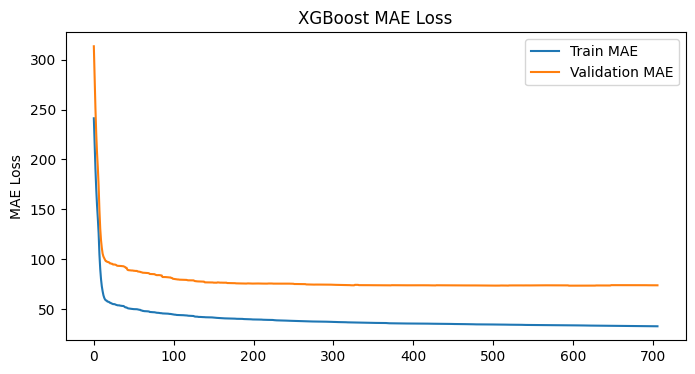

In [20]:
# Plot RMSE
results = clf.evals_result()
train_mae, val_mae = results["validation_0"]["mae"], results["validation_1"]["mae"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, label="Train MAE")
ax.plot(x_values, val_mae, label="Validation MAE")
ax.legend()
plt.ylabel("MAE Loss")
plt.title("XGBoost MAE Loss")
plt.show()

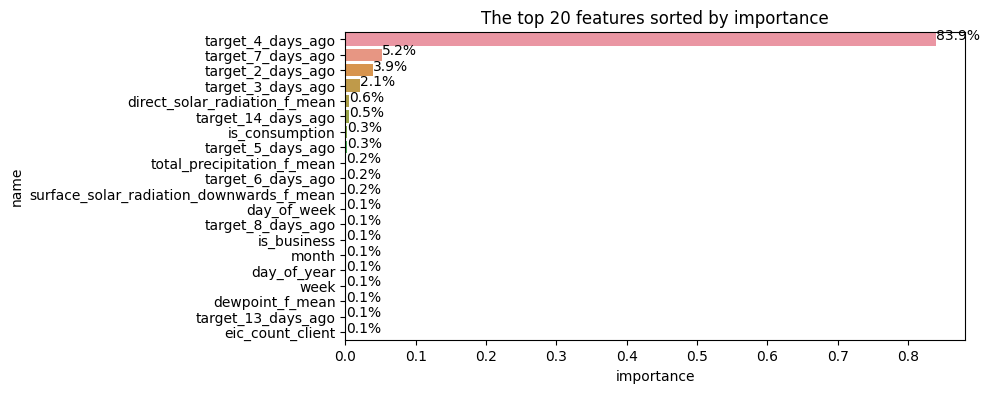

In [21]:
TOP = 20
importance_data = pd.DataFrame({'name': clf.feature_names_in_, 'importance': clf.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 100*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

In [22]:
importance_data[importance_data['importance']<0.0005].name.values

array(['county', 'highest_price_per_mwh_gas', 'day_of_month',
       'mean_price_per_mwh_gas', 'temperature_h_mean',
       'prediction_unit_id', 'year', 'target_11_days_ago',
       'cloudcover_low_h_mean', '10_metre_u_wind_component_f_mean',
       'cloudcover_total_f_mean', 'dewpoint_h_mean', 'target_10_days_ago',
       'euros_per_mwh_electricity', '10_metre_v_wind_component_f_mean',
       'surface_pressure_h_mean', 'cloudcover_mid_f_mean',
       'cloudcover_total_h_mean', 'winddirection_10m_h_mean',
       'cloudcover_mid_h_mean', 'rain_h_mean', 'cloudcover_high_f_mean',
       'windspeed_10m_h_mean', 'cloudcover_high_h_mean',
       'snowfall_h_mean'], dtype=object)

# Submit

In [23]:
def create_revealed_targets_test(data, previous_revealed_targets, N_day_lags):
    '''🎯 Create new test data based on previous_revealed_targets and N_day_lags 🎯 ''' 
    for count, revealed_targets in enumerate(previous_revealed_targets) :
        day_lag = count + 2
        
        # Get hour
        revealed_targets['hour'] = pd.to_datetime(revealed_targets['datetime']).dt.hour
        
        # Select columns and rename target
        revealed_targets = revealed_targets[['hour', 'prediction_unit_id', 'is_consumption', 'target']]
        revealed_targets = revealed_targets.rename(columns = {"target" : f"target_{day_lag}_days_ago"})
        
        
        # Add past revealed targets
        data = pd.merge(data,
                        revealed_targets,
                        how = 'left',
                        on = ['hour', 'prediction_unit_id', 'is_consumption'],
                       )
        
    # If revealed_target_columns not available, replace by nan
    all_revealed_columns = [f"target_{day_lag}_days_ago" for day_lag in range(2, N_day_lags+1)]
    missing_columns = list(set(all_revealed_columns) - set(data.columns))
    data[missing_columns] = np.nan 
    
    return data

In [24]:
import enefit
env = enefit.make_env()
iter_test = env.iter_test()

In [25]:
# Reload enefit environment (only in debug mode, otherwise the submission will fail)
if DEBUG:
    enefit.make_env.__called__ = False
    type(env)._state = type(type(env)._state).__dict__['INIT']
    iter_test = env.iter_test()

In [26]:
# List of target_revealed dataframes
previous_revealed_targets = []

for (test, 
     revealed_targets, 
     client_test, 
     historical_weather_test,
     forecast_weather_test, 
     electricity_test, 
     gas_test, 
     sample_prediction) in iter_test:
    
    # Rename test set to make consistent with train
    test = test.rename(columns = {'prediction_datetime': 'datetime'})

    # Initiate column data_block_id with default value to join on
    id_column = 'data_block_id' 
    
    test[id_column] = 0
    gas_test[id_column] = 0
    electricity_test[id_column] = 0
    historical_weather_test[id_column] = 0
    forecast_weather_test[id_column] = 0
    client_test[id_column] = 0
    revealed_targets[id_column] = 0
    
    data_test = FeatureProcessor(
                               data = test,
                               client = client_test, 
                               historical_weather = historical_weather_test,
                               forecast_weather = forecast_weather_test, 
                               electricity = electricity_test, 
                               gas = gas_test
                               )
    
    # Store revealed_targets
    previous_revealed_targets.insert(0, revealed_targets)
    
    if len(previous_revealed_targets) == N_day_lags:
        previous_revealed_targets.pop()
    
    # Add previous revealed targets
    df_test = create_revealed_targets_test(data = data_test.copy(),
                                           previous_revealed_targets = previous_revealed_targets.copy(),
                                           N_day_lags = N_day_lags
                                          )
    
    # Make prediction
    X_test = df_test[features]
    sample_prediction['target'] = clf.predict(X_test)
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:04:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


# Next steps
> 📌**Note**: If you liked or forked this notebook, please consider upvoting ⬆️⬆️ It encourages to keep posting relevant content. Feedback is always welcome!!

<div style="border-radius:10px; border: #babab5 solid; padding: 15px; background-color: #e6f9ff; font-size:100%;">

* Create more rolling / lag features and make sure they are robust on the test set
* Be creative with new feature engineering
* Cross validation and hyperparameter tuning
* Choose other models e.g. CatBoost, LGBM, Neural Networks (Transformers?) and ensemble  
* Alternative merging, not sure the merging I used is the most correct!